In [1]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import logging
logging.Logger.disabled=True

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings;
with warnings.catch_warnings():
    warnings.simplefilter("ignore"); 
    import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from scipy.fft import fft, fftfreq
import numpy as np
import unittest

import schemdraw
import schemdraw.elements as elm

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

from IPython.display import Javascript
from IPython.display import display, HTML

In [2]:

# display(HTML('''
# <script src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/3.5.0/chart.min.js" integrity="sha512-asxKqQghC1oBShyhiBwA+YgotaSYKxGP1rcSYTDrB0U6DxwlJjU59B67U8+5/++uFjcuVM8Hh5cokLjZlhm3Vg==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>
# '''))

# amplitude modulation

In amplitude modulation the amplitude (signal strength) of the carrier changes in proportion to the message signal.  






$$
\begin{array}{c}
c(t) = A \sin(2 \pi f_c t)\,
\end{array}
$$




Where A is the amplitude of the carrier singal and the function of f the modulation signal. Amplitude Modulation is a multiplication of the two signals. 

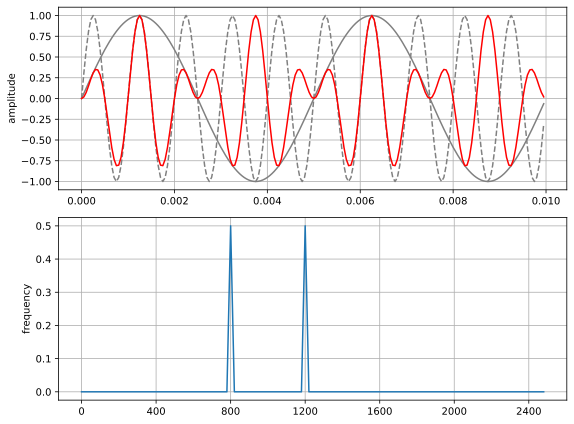

In [3]:
f1 = 1000
f2 = 200

N = 1000
# sample spacing
T = 1.0 / 20000.0
x = np.linspace(0.0, N*T, N, endpoint=False)

y1 = np.sin(f1 * 2.0 * np.pi * x)
y2 = np.sin(f2 * 2.0 * np.pi * x)
y3 = np.sin(f1 * 2.0 * np.pi * x) * np.sin(f2 * 2.0 * np.pi * x)
y4 = np.sin(f1 * 2.0 * np.pi * x) * np.sin(f2 * 2.0 * np.pi * x) + np.sin(f1 * 2.0 * np.pi * x)

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(8, 6))

#plot multiplication
ax0.plot(x[0:200], y1[0:200], c='Grey', linestyle='--')  # differential output
ax0.plot(x[0:200], y2[0:200], c='Grey')  # differential output
ax0.plot(x[0:200], y3[0:200], c='Red')  # differential output
ax0.set_ylabel('amplitude')
ax0.grid()

y = y3
yf = fft(y)
#print(yf.size)
xf = fftfreq(N, T)[:N//2]

ax1.plot(xf[0:125], 2.0/N * np.abs(yf[0:N//8]))
ax1.grid()
ax1.set_ylabel('frequency')
plt.xticks(np.arange(min(xf[0:250]), max(xf[0:125])+1, 400))

plt.tight_layout()
plt.show()


In [4]:
display(HTML('''
<div class="columns is-centered">
<div class="column is-half">
<div class="content has-text-centered">
<canvas id="myChart" class="400px"></canvas>
<canvas id="freq_chart" class="400px"></canvas>
<input type="range" class="slider-width" id="DSBSC" name="DSBSC" min="10" max="30" value="20" step="1"></input>
<p class="content">Figure 3: Linear Buffer Analysis.</p>
</div>
</div>
</div>
'''))

display(Javascript('''

var f1 = 200;
var f2 = 20;

var N = 1
var T = 1.0 / 2048.0

let time = [];
let y1 = [];
let y2 = [];
let y3 = [];

for (let i = 0; i < N; i=i+T) {
    time.push(i);
    y1.push(Math.sin(f1 * 2.0 * Math.PI * i));
    y2.push(Math.sin(f2 * 2.0 * Math.PI * i));
    y3.push(Math.sin(f1 * 2.0 * Math.PI * i) * Math.sin(f2 * 2.0 * Math.PI * i));    
}
time.length = 128;

freq = fft_freq(2048, T).slice(300, 500);
console.log( freq );

fft = fft_transform(y3, 2048).slice(300, 500);

const data = {
  labels: time,
    datasets: [
    {
      label: 'Input (200 Hz.)',
      data: y1,
      fill: false,
      borderColor: 'rgb(102, 178, 255)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'Input (20 Hz.)',
      data: y2,
      fill: false,
      borderColor: 'rgb(102, 255, 102)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'Input',
      data: y3,
      fill: false,
      borderColor: 'rgb(255, 0, 0)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 4
    },

    ]
};
var ctx = document.getElementById('myChart').getContext('2d');
var myChart = new Chart(ctx, {
    type: 'line',
    data: data,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
        scales: {
            x: {
                title: {
                    display: true,
                    text: '[ms]'
                },
                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                }
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
/*                min: -3,
                max: 3,
                ticks: {
                    stepSize: 0.5
                } */
            }
        },
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});


const freq_data = {
  labels: freq,
    datasets: [
    {
      label: 'Input',
      data: fft,
      fill: false,
      borderColor: 'rgb(0, 0, 204)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 4
    },
    ]
};
var freq_ctx = document.getElementById('freq_chart').getContext('2d');
var freq_chart = new Chart(freq_ctx, {
    type: 'line',
    data: freq_data,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
        scales: {
            x: {
                title: {
                    display: true,
                    text: '[Hz.]'
                },
                ticks: {
                    callback: function(value, index) {
                        console.log(this.getLabelForValue(value));
                        if(this.getLabelForValue(value) % 20 == 0) {
                            return this.getLabelForValue(value);
                        } else return '';
                    }                
                }
            },
            /* y: {
                title: {
                    display: true,
                    text: '[V]'
                },
                min: -3,
                max: 3,
                ticks: {
                    stepSize: 0.5
                } 
            } */
        }, 
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});

let DBSC = document.getElementById('DSBSC');
DSBSC.addEventListener('input', function (e) {
    var y1 = [];
    var y2 = [];
    for (let i = 0; i < N; i=i+T) {
        y1.push(Math.sin(DBSC.value * 2.0 * Math.PI * i));    
        y2.push(Math.sin(f1 * 2.0 * Math.PI * i) * Math.sin(DBSC.value * 2.0 * Math.PI * i));    
    }

    fft = fft_transform(y2, 2048).slice(300, 500);

    myChart.data.datasets[2].data = y2;
    myChart.data.datasets[1].data = y1;
    myChart.data.datasets[1].label = 'Input (' + DBSC.value + ' Hz.)';
    freq_chart.data.datasets[0].data = fft;
    freq_chart.update();
    myChart.update();
    

});
'''))

<IPython.core.display.Javascript object>

Here the carrier frequency is 1kHz and the modulation frequency is 200Hz. The carrier frequency is modulated by the modulation frequency. When the modulation signal is negative the resulting signal has a phase shift of 180°. The frequency analysis shows that the two sidebands are created at 800Hz and 1200Hz. The modulation frequency is added and subtracted from the base frequency. This is called a double-sideband with suppressed carrier (DSBSC).

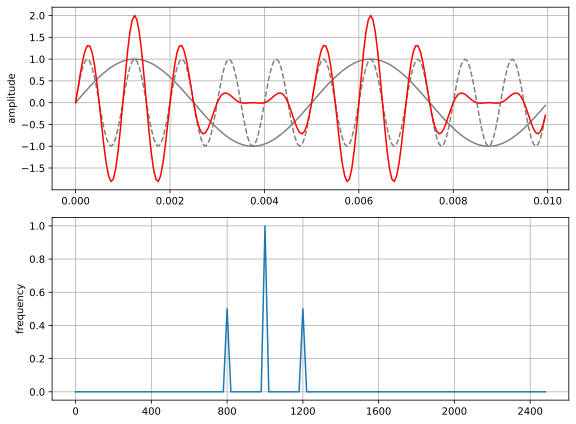

In [5]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(8, 6))

#plot multiplication with carrier added
ax0.plot(x[0:200], y1[0:200], c='Grey', linestyle='--')  # differential output
ax0.plot(x[0:200], y2[0:200], c='Grey')  # differential output
ax0.plot(x[0:200], y4[0:200], c='Red')  # differential output
ax0.grid()
ax0.set_ylabel('amplitude')

y = y4
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
ax1.plot(xf[0:125], 2.0/N * np.abs(yf[0:N//8]))
ax1.set_ylabel('frequency')
plt.xticks(np.arange(min(xf[0:250]), max(xf[0:125])+1, 400))
ax1.grid()

plt.tight_layout()
plt.show()

In [6]:
display(HTML('''
<div class="columns is-centered">
<div class="column is-half">
<div class="content has-text-centered">
<canvas id="dsbfcChart" class="400px"></canvas>
<canvas id="dsbfc_freq_chart" class="400px"></canvas>
<input type="range" class="slider-width" id="DSBFC" name="DSBFC" min="10" max="30" value="20" step="1"></input>
<p class="content">Figure 4: Amplitude Modulation (DSBFC).</p>
</div>
</div>
</div>
'''))

display(Javascript('''

var dsbfc_f1 = 100;
var dsbfc_f2 = 20;

//var N = 1
//var T = 1.0 / 1024.0

let dsbfc_time = [];
let dsbfc_y1 = [];
let dsbfc_y2 = [];
let dsbfc_y3 = [];

for (let i = 0; i < N; i=i+T) {
    dsbfc_time.push(i);
    dsbfc_y1.push(Math.sin(dsbfc_f1 * 2.0 * Math.PI * i));
    dsbfc_y2.push(Math.sin(dsbfc_f2 * 2.0 * Math.PI * i));
    dsbfc_y3.push(Math.sin(dsbfc_f1 * 2.0 * Math.PI * i) * Math.sin(dsbfc_f2 * 2.0 * Math.PI * i)+Math.sin(dsbfc_f1 * 2.0 * Math.PI * i));  
}
dsbfc_time.length = 128;

dsbfc_frq = fft_freq(256, T);
dsbfc_fft = fft_transform(dsbfc_y3, 256);

const dsbfc_data = {
  labels: dsbfc_time,
    datasets: [
    {
      label: 'Input',
      data: dsbfc_y1,
      fill: false,
      borderColor: 'rgb(224, 224, 224)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'Output',
      data: dsbfc_y2,
      fill: false,
      borderColor: 'rgb(224, 224, 224)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'Input',
      data: dsbfc_y3,
      fill: false,
      borderColor: 'rgb(0, 0, 204)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 4
    },

    ]
};
var dsbfc_ctx = document.getElementById('dsbfcChart').getContext('2d');
var dsbfcChart = new Chart(dsbfc_ctx, {
    type: 'line',
    data: dsbfc_data,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
        scales: {
            x: {
                title: {
                    display: true,
                    text: '[ms]'
                },
                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                }
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
/*                min: -3,
                max: 3,
                ticks: {
                    stepSize: 0.5
                } */
            }
        },
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});


const dsbfc_freq_data = {
  labels: dsbfc_frq,
    datasets: [
    {
      label: 'Input',
      data: dsbfc_fft,
      fill: false,
      borderColor: 'rgb(0, 0, 204)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 4
    },
    ]
};
var freq_ctx = document.getElementById('dsbfc_freq_chart').getContext('2d');
var dsbfc_freq_chart = new Chart(freq_ctx, {
    type: 'line',
    data: dsbfc_freq_data,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
/*        scales: {
            x: {
                title: {
                    display: true,
                    text: '[ms]'
                },
                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                }
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
                min: -3,
                max: 3,
                ticks: {
                    stepSize: 0.5
                } 
            }
        }, */
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});

let DSBFC = document.getElementById('DSBFC');
DSBFC.addEventListener('input', function (e) {
    var y = [];
    for (let i = 0; i < N; i=i+T) {
        y.push(Math.sin(dsbfc_f1 * 2.0 * Math.PI * i) * Math.sin(DSBFC.value * 2.0 * Math.PI * i)+Math.sin(dsbfc_f1 * 2.0 * Math.PI * i));  
    }

    dsbfc_fft = fft_transform(y, 256);

    dsbfcChart.data.datasets[2].data = y;
    dsbfc_freq_chart.data.datasets[0].data = dsbfc_fft;
    dsbfc_freq_chart.update();
    dsbfcChart.update();
    

});
'''))

<IPython.core.display.Javascript object>

When the carrier frequency is added to the result, we see two things. First, the final signal is not phase-shifted when the base signal is negative. Second, the carrier signal is part of the final signal. This is basic amplitude modulation. but notice that the output amplitude is twice the input.

# filter frequency



In [7]:
val = float(600000 * 600000 * 0.0000000047 * 0.000000001)
break_frequency = 1 / (2 * math.pi * float( math.sqrt( val ) ) )
print( break_frequency )
print("Break frequency = {:.1f} Hz".format(break_frequency))

122.35450159527888
Break frequency = 122.4 Hz


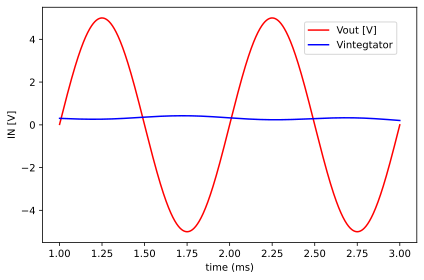

/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:36: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, gain, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:46: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, phase, basex=10, **kwargs)


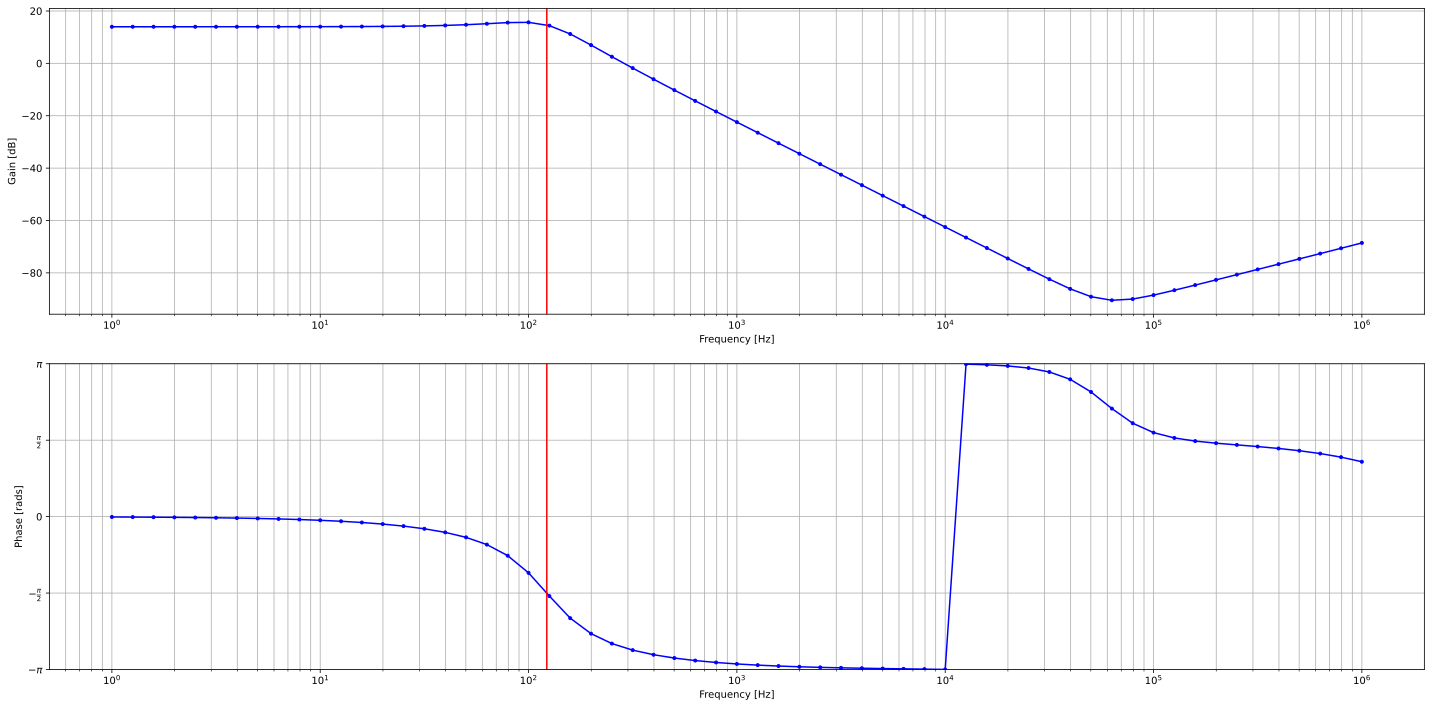

In [8]:
circuit = Circuit('sallen_key_filter')
circuit.include(spice_library['TL072'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'IN', circuit.gnd, 'DC 5V AC 5V SIN(0 5V 1k)')

#circuit.R(1, 'IN', circuit.gnd, 100@u_kΩ)
#circuit.C(1, 'IN', 'C1', 1@u_uF)
#circuit.R(2, 'C1', circuit.gnd, 100@u_kΩ)
circuit.X(1, 'TL072', 'IN', 'X1n', '+15V', '-15V', 'X1o')
circuit.R(3, 'X1n', 'X1o', 15@u_kΩ)

circuit.R(4, 'X1o', 'R4', 600@u_kΩ)
circuit.R(5, 'R4', 'R5', 600@u_kΩ)

circuit.C(2, 'R5', circuit.gnd, 1@u_nF)
#Resistor

circuit.X(2, 'TL072', 'R5', 'X2n', '+15V', '-15V', 'OUT')
circuit.R(6, 'X2n', 'OUT', 10@u_kΩ)
circuit.C(3, 'OUT', 'R4', 4.7@u_nF)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
#simulator.initial_condition(OUTi=0.0)
analysis  = simulator.transient(step_time=1@u_us, start_time=1@u_ms, end_time=3@u_ms)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_MHz, number_of_points=10,  variation='dec')

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Red')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Blue')
ax1_buffer.legend(('Vout [V]', 'Vintegtator'), loc=(0.7,0.8))

plt.tight_layout()
plt.show()



figure = plt.figure(1, (20, 10))
plt.title("Bode Diagram of a Low-Pass RC Filter")
axes = (plt.subplot(211), plt.subplot(212))
bode_diagram(axes=axes,
             frequency=analysis_ac.frequency,
             gain=20*np.log10(np.absolute(analysis_ac.out)),
             phase=np.angle(analysis_ac.out, deg=False),
             marker='.',
             color='blue',
             linestyle='-',
         )
for axe in axes:
    axe.axvline(x=break_frequency, color='red')

plt.tight_layout()
plt.show()




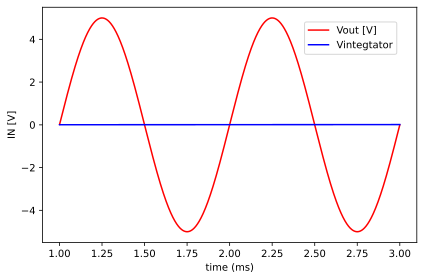

/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:36: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, gain, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:46: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, phase, basex=10, **kwargs)


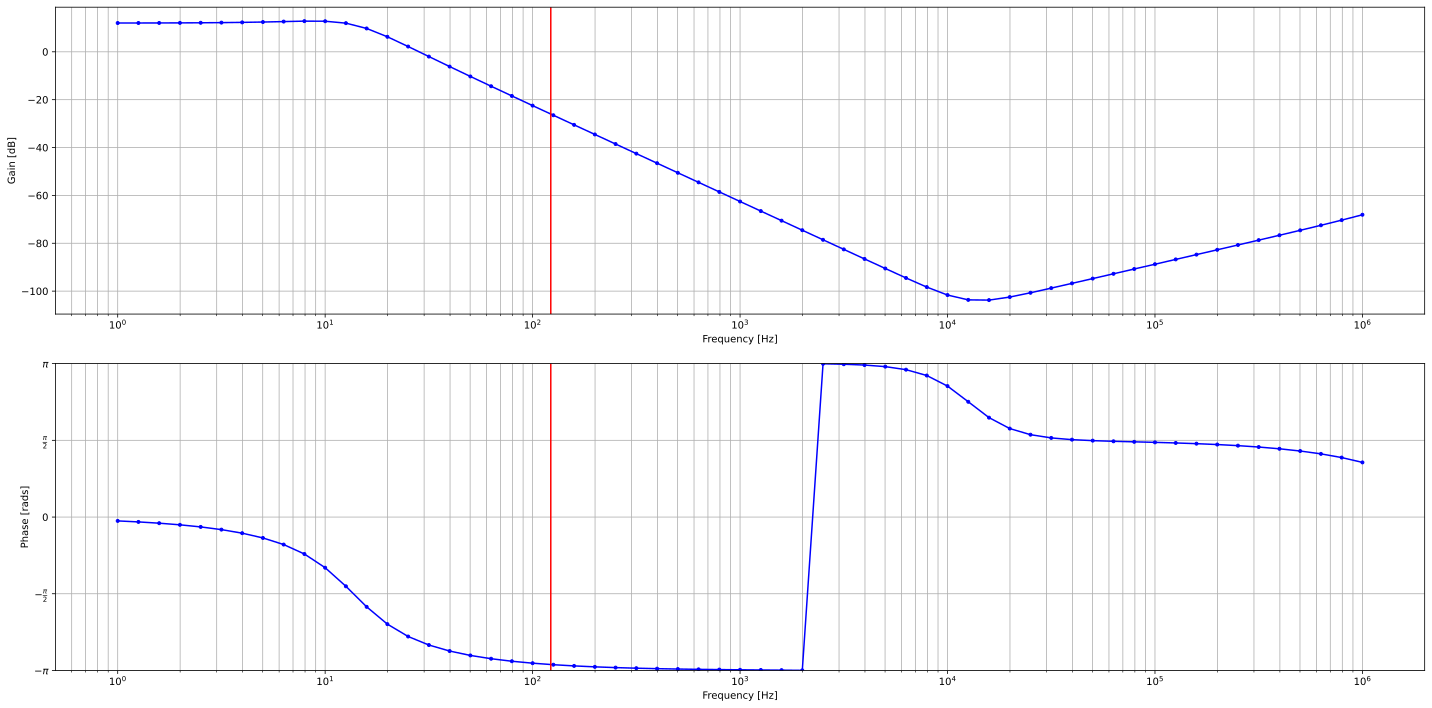

In [9]:
circuit = Circuit('sallen_key_filter')
circuit.include(spice_library['TL072'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'IN', circuit.gnd, 'DC 5V AC 5V SIN(0 5V 1k)')

#circuit.R(1, 'IN', circuit.gnd, 100@u_kΩ)
#circuit.C(1, 'IN', 'C1', 1@u_uF)
#circuit.R(2, 'C1', circuit.gnd, 100@u_kΩ)
circuit.X(1, 'TL072', 'IN', 'X1n', '+15V', '-15V', 'X1o')
circuit.R(3, 'X1n', 'X1o', 15@u_kΩ)

circuit.R(4, 'X1o', 'R4', 600@u_kΩ)
circuit.R(5, 'R4', 'R5', 600@u_kΩ)

circuit.C(2, 'R5', circuit.gnd, 10@u_nF)
circuit.R(10, 'R5', circuit.gnd, 4.7@u_MΩ)
#Resistor

circuit.X(2, 'TL072', 'R5', 'X2n', '+15V', '-15V', 'OUT')
circuit.R(6, 'X2n', 'OUT', 10@u_kΩ)
circuit.C(3, 'OUT', 'R4', 47@u_nF)
circuit.C(4, 'R4', circuit.gnd, 220@u_pF)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
#simulator.initial_condition(OUTi=0.0)
analysis  = simulator.transient(step_time=1@u_us, start_time=1@u_ms, end_time=3@u_ms)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_MHz, number_of_points=10,  variation='dec')

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Red')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Blue')
ax1_buffer.legend(('Vout [V]', 'Vintegtator'), loc=(0.7,0.8))

plt.tight_layout()
plt.show()



figure = plt.figure(1, (20, 10))
plt.title("Bode Diagram of a Low-Pass RC Filter")
axes = (plt.subplot(211), plt.subplot(212))
bode_diagram(axes=axes,
             frequency=analysis_ac.frequency,
             gain=20*np.log10(np.absolute(analysis_ac.out)),
             phase=np.angle(analysis_ac.out, deg=False),
             marker='.',
             color='blue',
             linestyle='-',
         )
for axe in axes:
    axe.axvline(x=break_frequency, color='red')

plt.tight_layout()
plt.show()




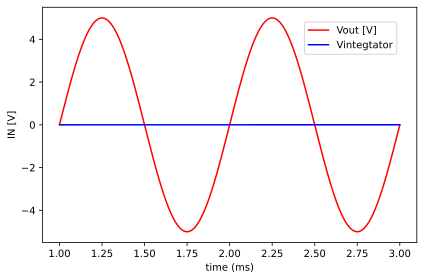

/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:36: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, gain, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:46: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, phase, basex=10, **kwargs)


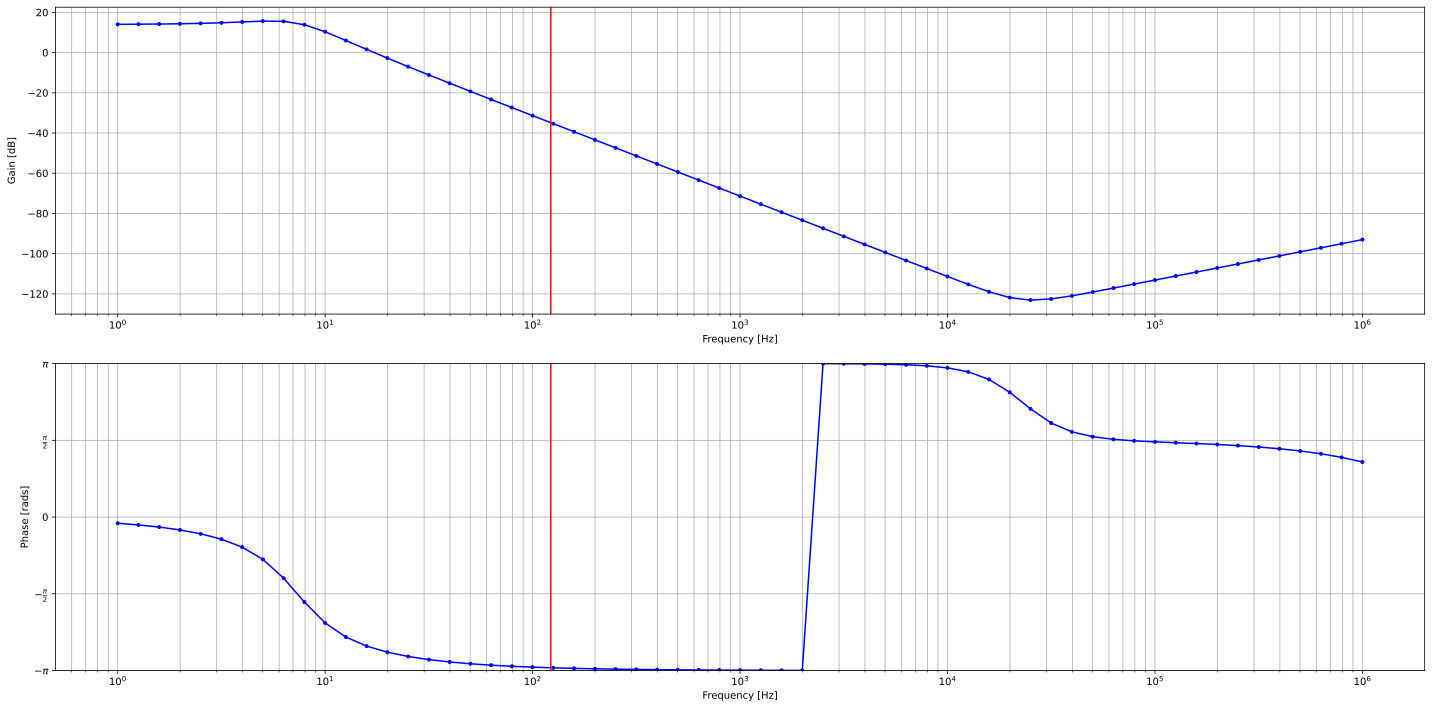

In [10]:
circuit = Circuit('sallen_key_filter')
circuit.include(spice_library['TL072'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'IN', circuit.gnd, 'DC 5V AC 5V SIN(0 5V 1k)')

#circuit.R(1, 'IN', circuit.gnd, 100@u_kΩ)
#circuit.C(1, 'IN', 'C1', 1@u_uF)
#circuit.R(2, 'C1', circuit.gnd, 100@u_kΩ)
circuit.X(1, 'TL072', 'IN', 'X1n', '+15V', '-15V', 'X1o')
circuit.R(3, 'X1n', 'X1o', 15@u_kΩ)

circuit.R(4, 'X1o', 'R4', 10@u_MΩ)
circuit.R(5, 'R4', 'R5', 10@u_MΩ)

circuit.C(2, 'R5', circuit.gnd, 1@u_nF)
#circuit.R(10, 'R5', circuit.gnd, 4.7@u_MΩ)
#Resistor

circuit.X(2, 'TL072', 'R5', 'X2n', '+15V', '-15V', 'OUT')
circuit.R(6, 'X2n', 'OUT', 10@u_kΩ)
circuit.C(3, 'OUT', 'R4', 4.7@u_nF)
#circuit.C(4, 'R4', circuit.gnd, 220@u_pF)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
#simulator.initial_condition(OUTi=0.0)
analysis  = simulator.transient(step_time=1@u_us, start_time=1@u_ms, end_time=3@u_ms)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_MHz, number_of_points=10,  variation='dec')

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Red')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Blue')
ax1_buffer.legend(('Vout [V]', 'Vintegtator'), loc=(0.7,0.8))

plt.tight_layout()
plt.show()



figure = plt.figure(1, (20, 10))
plt.title("Bode Diagram of a Low-Pass RC Filter")
axes = (plt.subplot(211), plt.subplot(212))
bode_diagram(axes=axes,
             frequency=analysis_ac.frequency,
             gain=20*np.log10(np.absolute(analysis_ac.out)),
             phase=np.angle(analysis_ac.out, deg=False),
             marker='.',
             color='blue',
             linestyle='-',
         )
for axe in axes:
    axe.axvline(x=break_frequency, color='red')

plt.tight_layout()
plt.show()




# Long tailed pair

The long-tailed pair or differential amplifier is probably the most widely used circuit building block. For example, the long-tailed pair is the base for op-amps. Also in synthesizer circuits, we see the long-tailed pair a lot for converting CV signals into current. This circuit can be implemented with BJTs or MOSFETs. The differential pair multiplies the voltage difference between the two inputs with the differential gain. The differential gain can be configured with the current in the long tail. The output can be taken either from one side or the difference from both sides. 

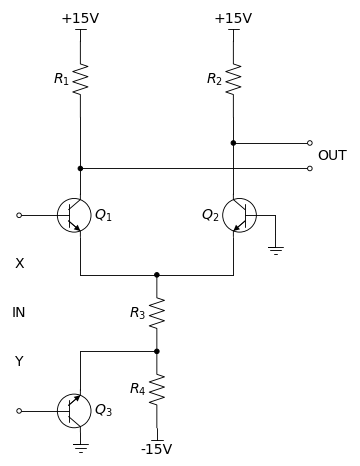

In [11]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)

Q1 = d.add(elm.BjtNpn( label='$Q_1$', circle=True))
d.add(elm.Line("up"))
d.add(elm.Resistor( "up", label="$R_1$"))
d.add(elm.Vdd(label="+15V"))

IN_X = d.add(elm.Line("left", l=d.unit/2, xy=Q1.base))
d.add(elm.Dot('left', open=True))

L_Q1_emmitter = d.add(elm.Line("down",  xy=Q1.emitter, l=d.unit/2))
d.add(elm.Line("right", l=d.unit*2))
d.add(elm.Line("up", l=d.unit/2))
Q2 = d.add(elm.BjtNpn("right", lftlabel='$Q_2$', anchor="emitter", circle=True, reverse=True))
d.add(elm.Line("up", xy=Q2.collector))
d.add(elm.Resistor( "up", label="$R_2$"))
d.add(elm.Vdd(label="+15V"))

d.add(elm.Line("right", xy=Q2.base, l=d.unit/4))
d.add(elm.Line("down", l=d.unit/4))
d.add(elm.Ground())

d.add(elm.Dot(xy=[L_Q1_emmitter.end[0]+d.unit, L_Q1_emmitter.end[1]]))
R3 = d.add(elm.Resistor( "down", label="$R_3$"))
d.add(elm.Dot())
d.add(elm.Resistor( "down", label="$R_4$"))
d.add(elm.Vss(botlabel="-15V"))

d.add(elm.Line("left", l=d.unit, xy=R3.end))
d.add(elm.Line("down", l=d.unit/2))
Q3 = d.add(elm.BjtNpn("right", rgtlabel='$Q_3$', anchor="emitter", circle=True, flip=True))
d.add(elm.Ground(xy=Q3.collector))
IN_Y = d.add(elm.Line("left", xy=Q3.base, tox=IN_X.end))
d.add(elm.Dot('left', open=True))
d.add(elm.Gap('down', xy=IN_X.end, toy=IN_Y.end, label=['X', 'IN', 'Y']))

d.add(elm.Dot(xy=[Q1.collector[0], Q1.collector[1]+d.unit/3]))
L_OUT_A = d.add(elm.Line("right", l=d.unit*3))
d.add(elm.Dot('right', open=True))
d.add(elm.Dot(xy=[Q2.collector[0], Q2.collector[1]+d.unit/3*2]))
L_OUT_B = d.add(elm.Line("right", tox=L_OUT_A.end))
d.add(elm.Dot('right', open=True))

d.add(elm.Label('right', xy=[L_OUT_A.end[0]+d.unit/4, L_OUT_A.end[1]+d.unit/8], label='OUT'))

d.draw()

In this typical vca configuration, the audio signal is applied to the transistor Q1 where Q2 is grounded. The multiplication factor, or current, is set with the transistor Q3. The output is the difference of OUTa and OUTb (OUTb - OUTa). 

In [12]:
circuit = Circuit('differential pair')
circuit.include(spice_library['BC547B'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'IN_a', circuit.gnd, 'DC 0V AC 0V SIN(0 25m 1k)')
circuit.V('4', 'IN_b', circuit.gnd, 'DC 0V AC 0V SIN(0 5 100)')

circuit.BJT('1', 'OUT_A', 'IN_a', 'R3_in', model="BC547B")
circuit.BJT('2', 'OUT_B', circuit.gnd, 'R3_in', model="BC547B")
circuit.BJT('3', circuit.gnd, 'IN_b', 'R3_out', model="BC547B")

circuit.R(1, 'OUT_A', '+15V', 15@u_kΩ)
circuit.R(2, 'OUT_B', '+15V', 15@u_kΩ)
circuit.R(3, 'R3_in', 'R3_out', 33@u_kΩ)
R4 = circuit.R(4, 'R3_out', '-15V', 15@u_kΩ)


In [13]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=20@u_ms)

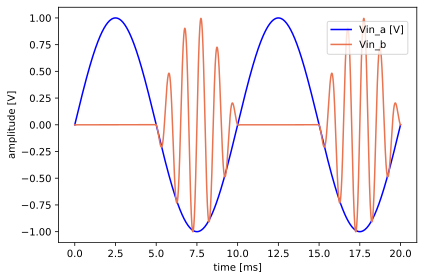

In [14]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
#ax1_buffer.plot(u_ms(analysis['IN_a'].abscissa), analysis['IN_a'], color='Blue')
ax1_buffer.plot(u_ms(analysis['IN_b'].abscissa), analysis['IN_b'] / 5, color='Blue')
#ax1_buffer.plot(u_ms(analysis['OUT_A'].abscissa), analysis['OUT_A'], color='Grey')
#ax1_buffer.plot(u_ms(analysis['OUT_A'].abscissa), analysis['OUT_B'], color='Grey')
ax1_buffer.plot(u_ms(analysis['OUT_A'].abscissa), analysis['OUT_A'] - analysis['OUT_B'], color='#E97451')
ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()

In [15]:
from IPython.display import display, HTML
display(HTML('''
<div class="section">
<div class="container">
<div class="content">
<canvas id="myChart" width="600" height="500px"></canvas>
</div>
</div>
</div>
'''))


In [16]:
import json

data = []
diff = (analysis['OUT_A'] - analysis['OUT_B'])
out = []
labels = []
for item in analysis['IN_b'] :
    value = float(item)
    data.append(value/5)

for item in diff :
    value = float(item)
    out.append(value)
    
for item in analysis['IN_b'].abscissa :
    label = float(item)
    labels.append(label*1000)


The output (red) is the signal multiplied by the input at the long tail. But we see that only the negative signal creates amplification. When the signal is positive the output is silent. This circuit can be useful for a VCA where a DC envelope is applied.

# gilbert cell

Another circuit for the multiplication of two signals is the Gilbert Cell. Although everybody calls it the Gilbert Cell, it is not invented by [Barrie Gilbert](https://en.wikipedia.org/wiki/Barrie_Gilbert). The circuit was first used by Howard Jones in 1963. But Barrie Gilbert invented and augmented it independently and made it a common building block in analog electronics. The Gilbert Cell essentially comprises two differential transistor pairs whose bias current is controlled by one of the input signals.

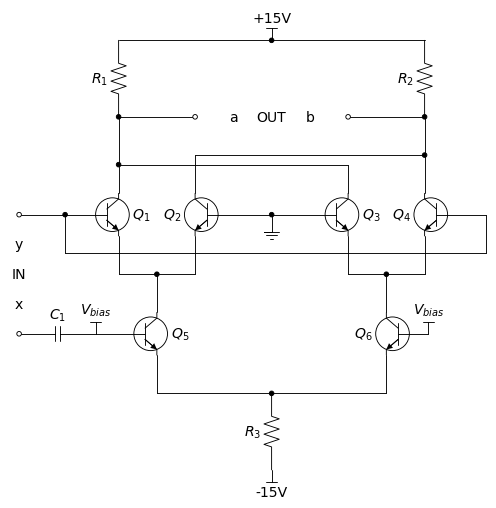

In [17]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)

d += (Q1 := elm.BjtNpn(circle=True).label('$Q_1$'))
d += elm.Line().left().at((Q1, 'base'))
d += (INa := elm.Dot(open=True))
d += elm.Line().up().at((Q1, 'collector'))
d += (R1 := elm.Resistor().up().label('$R_{1}$'))
d += (L1 := elm.Line().right().length(d.unit*2))
d += elm.Dot()
d += elm.Vdd().label('+15V')
d += elm.Line().right().length(d.unit*2)
d += ( R2 := elm.Resistor().down().label('$R_{2}$') )
d += elm.Line().down()
d += (Q4 := elm.BjtNpn(circle=True, anchor='collector').left().flip().label('$Q_4$', loc="lft"))

d += elm.Line().right().length(d.unit/2).at((Q4, 'base'))
d += elm.Line().down().length(d.unit/2)
d += elm.Line().left().length(d.unit*5.5)
d += elm.Line().up().length(d.unit/2)
d += elm.Dot()

d += elm.Dot().at((R1, 'start'))
d += (OUTa := elm.Line().right())
d += elm.Dot(open=True)
d += elm.Dot().at((R2, 'end'))
d += (OUTb := elm.Line().left())
d += elm.Dot(open=True)
d += (G := elm.Gap().left().tox(OUTa.end).label(['b', 'OUT', 'a']))

d += elm.Line().down().at((Q1, 'emitter')).length(d.unit/2)
d += (L2 := elm.Line().right().length(d.unit/2))
d += elm.Dot()
d += elm.Line().down().length(d.unit/2)
d += (Q5 := elm.BjtNpn(circle=True, anchor='collector').right().label('$Q_5$'))
d += elm.Line().down().length(d.unit/2).at((Q5, 'emitter'))
d += elm.Line().right().length(d.unit*1.5)
d += (Lmin := elm.Dot())
d += elm.Resistor().down().label('$R_3$')
d += elm.Vss().label('-15V', loc='bot')

d += elm.Line().right().at(Lmin.end).length(d.unit*1.5)
d += elm.Line().up().length(d.unit/2)
d += (Q6 := elm.BjtNpn(circle=True, anchor='emitter').left().flip().label('$Q_6$', loc="lft"))
d += (L4 := elm.Line().up().length(d.unit/2).at((Q6, 'collector')))
d += elm.Dot()
d += elm.Line().left().length(d.unit/2)
d += elm.Line().up().length(d.unit/2)
d += (Q3 := elm.BjtNpn(circle=True, anchor='emitter').right().label('$Q_3$'))
d += elm.Line().up().at((Q3, 'collector')).length(d.unit/2-d.unit/8)
d += elm.Line().left().length(d.unit*3)
d += elm.Dot()
d += elm.Line().right().length(d.unit/2).at((L4, 'end'))
d += elm.Line().up().length(d.unit/2)

d += elm.Line().at((Q6, 'base')).right().length(d.unit/4)
d += elm.Vdd().label('$V_{bias}$')

d += elm.Line().left().length(d.unit/2).at((Q5, 'base'))
d += (C1 := elm.Capacitor().left().label('$C_1$'))
d += elm.Dot(open=True)
d += (elm.Gap().up().toy(INa.end).label(['x', 'IN', 'y']))
d += elm.Vdd().label('$V_{bias}$').at((C1, 'start'))

d += elm.Line().right().length(d.unit/2).at((L2, 'end'))
d += elm.Line().up().length(d.unit/2)
d += (Q2 := elm.BjtNpn(circle=True, anchor='emitter').left().flip().label('$Q_2$', loc="lft"))
d += elm.Line().up().at((Q2, 'collector')).length(d.unit/2)
d += elm.Line().right().length(d.unit*3)
d += elm.Dot()

d += ( Lgnd := elm.Line().right().at((Q2, 'base')).length(d.unit*0.7))
d += elm.Dot()
d += elm.Line().right().tox(Q3.base)
d += elm.Line().down().at(Lgnd.end).length(d.unit/16)
d += elm.Ground()

d.draw()

It is not so easy to create a discrete Gilbert Cell. All the transistors have to be matched. The most tricky part is the biasing of the input signals. Here the audio signal is biased with a voltage of -7.5V (Vbias). The carrier is biased by the -15V in the long tail. This allows, that the carrier signal can also be a DC signal, like an envelope. This is a very crude implementation of a Gilbert Cell, which most likely is not precise and would add a lot of noise to the output.

In [18]:
circuit = Circuit('gilbert cell')
circuit.include(spice_library['BC547B'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'IN_x', circuit.gnd, 'DC 0V AC 0V SIN(0 10m 1k)')
circuit.V('4', 'IN_y', circuit.gnd, 'DC 0V AC 0V SIN(0 20m 100)')
circuit.V('5', 'Vbias', circuit.gnd, 'DC -7.5V')

circuit.R(1, 'OUT_a', '+15V', 720@u_Ω)
circuit.R(2, 'OUT_b', '+15V', 720@u_Ω)
circuit.R(3, 'R3_in', '-15V', 720@u_Ω)

circuit.R(4, 'R4_out', 'Vbias', 2.2@u_kΩ)
circuit.R(5, 'R5_out', 'Vbias', 2.2@u_kΩ)

circuit.C(1, 'IN_x', 'R4_out', 0.22@u_uF)

# collector, base, emitter
circuit.BJT('1', 'OUT_a', 'IN_y', 'emitter_left', model="BC547B")
circuit.BJT('2', 'OUT_b', circuit.gnd, 'emitter_left', model="BC547B")
circuit.BJT('3', 'OUT_a', circuit.gnd, 'emitter_right', model="BC547B")
circuit.BJT('4', 'OUT_b', 'IN_y', 'emitter_right', model="BC547B")
circuit.BJT('5', 'emitter_left', 'R4_out', 'R3_in', model="BC547B")
circuit.BJT('6', 'emitter_right', 'R5_out', 'R3_in', model="BC547B")

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=20@u_ms)

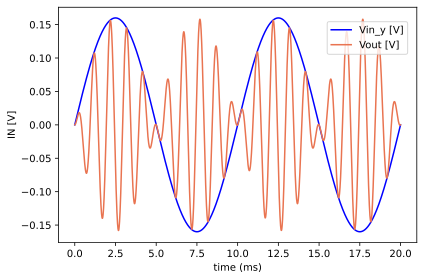

In [19]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
#ax1_buffer.plot(u_ms(analysis['IN_x'].abscissa), analysis['IN_x']*15, color='Blue')
ax1_buffer.plot(u_ms(analysis['IN_y'].abscissa), analysis['IN_y']*8, color='Blue')
ax1_buffer.plot(u_ms(analysis['OUT_a'].abscissa), (analysis['OUT_b'] - analysis['OUT_a']), color='#E97451')
ax1_buffer.legend(('Vin_y [V]', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()

The plot shows, that the Gilbert Cell does work as excpected and creates real amplitude modulation with double sideband and supressed carrier.

# Analog Multiplier

We saw that multiple types of multiplier circuits behave differently. Of course, this is a well-defined behaviour. The multipliers are classified in three types. The types are called quadrants. In the following table the different quadrants are listed and for which signal type they can be used.

|Type|X [V]| Y  [V]| Out [V]|
|--- |---  |---    |---     |
|1-Quadrant|Unipolar|Unipolar|Unipolar|
|2-Quadrant|Bipolar|Unipolar|Bipolar|
|4-Quadrant|Bipolar|Bipolar|Bipolar|

The simulation showed that the long-tailed pair is a 2-quadrant multiplier. The X signal can be an audio signal but the Y signal has to be unipolar, for example, an envelope. In contrast, the Gilbert Cell is a four-quadrant multiplier and allows both signals to be bipolar. The Gilbert Cell can be used as a Ring Modulator. of course, a 4-quadrant multiplier also works correctly when one signal is unipolar. But the output signal would be the same as with a 2-quadrant multiplier. 

# conclusion

There are different circuits for multiplication of signals. The choice of the circuit depends on the nature of the signal and the required functions we want to apply to them. Here only circuits using BJT's are shown. The downside of these circuits is that all the transistors have to be properly matched. In my experience, they are also very sensitive to noise. My take on a discrete Gilbert Cell produced to much noise to be useful. There are also integrated circuits which implement a VCA or multiplier available. For a simple VCA the [LM13700](https://www.ti.com/lit/ds/symlink/lm13700.pdf) is a good choice. There are also integrated circuits available which implement the Gilbert Cell. One example is the [AD633](https://www.analog.com/media/en/technical-documentation/data-sheets/AD633.pdf) from Analog Devices. This chip is very handy, it offers the right input and output impedances. No buffering or biasing of the signals is necessary. It is a very precise multiplier, which of course has some price. 

# references

* [LM13700](https://www.ti.com/lit/ds/symlink/lm13700.pdf) Datasheet
* [AD633](https://www.analog.com/media/en/technical-documentation/data-sheets/AD633.pdf) Datasheet
* VCA Techniques Investigated by [Rod Elliott (ESP)](https://sound-au.com/articles/vca-techniques.html)